In [26]:
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import pandas as pd
from torchsummary import summary
from safetensors.torch import save_model, load_model
import matplotlib.pyplot as plt
import cv2

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Data Manipulation

In [28]:
frames = []
i = 0
cap = cv2.VideoCapture("data/Skyfinder/apache1.mp4")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if i % 5 == 0:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    i = i + 1
cap.release()

len(frames)

231

In [29]:
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [30]:
class FrameDataset(Dataset):
    def __init__(self, frames, transform=None):
        self.frames = frames
        self.transform = transform
        
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        frame = self.frames[idx]
        frame = Image.fromarray(frame)

        if self.transform:
            frame = self.transform(frame)
            
        return frame

In [31]:
video_ds = FrameDataset(frames, data_transforms)

In [32]:
batch_size = 16

# put custom dataset to dataloader
dl = DataLoader(video_ds, batch_size=batch_size, shuffle=True)

In [33]:
# check shapes of dataloader
feature = next(iter(dl))
feature

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

### Create Model

A VAE is just like an Autoencoder but the latent vector is now represnted as Gaussians

In [34]:
input_dim = 3*128*128
output_dim = input_dim
hidden_dim = 4096
latent_dim = 2048

In [35]:
class Encoder(nn.Module):
    def __init__(self, input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim):
        super(Encoder, self).__init__()

        self.en_input = nn.Linear(input_dim, hidden_dim)
        self.en_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.en_mean = nn.Linear(hidden_dim, latent_dim)
        self.en_var = nn.Linear(hidden_dim, latent_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.en_input(x)
        x = self.relu(x)

        x = self.en_hidden(x)
        x = self.relu(x)

        mean = self.en_mean(x) # means and variance under log
        var = self.en_var(x)

        return mean, var

In [36]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim):
        super(Decoder, self).__init__()

        self.de_input = nn.Linear(latent_dim, hidden_dim)
        self.de_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.de_out = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.de_input(x)
        x = self.relu(x)

        x = self.de_hidden(x)
        x = self.relu(x)

        x = self.de_out(x)
        x = torch.sigmoid(x)

        return x

In [37]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()

        self.Encoder = Encoder
        self.Decoder = Decoder

    def rep(self, mean, var):
        e = torch.randn_like(var).to(device)
        z = mean + var * e
        return z
    
    def forward(self, x):
        mean, var = self.Encoder(x)
        z = self.rep(mean, torch.exp(0.5 * var)) # log var -> var
        x = self.Decoder(z)

        return x, mean, var

encoder = Encoder()
decoder = Decoder()
model = VAE(Encoder=encoder, Decoder=decoder).to(device)

summary(model, (16, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 16, 4096]     201,330,688
              ReLU-2             [-1, 16, 4096]               0
            Linear-3             [-1, 16, 4096]      16,781,312
              ReLU-4             [-1, 16, 4096]               0
            Linear-5             [-1, 16, 2048]       8,390,656
            Linear-6             [-1, 16, 2048]       8,390,656
           Encoder-7  [[-1, 16, 2048], [-1, 16, 2048]]               0
            Linear-8             [-1, 16, 4096]       8,392,704
              ReLU-9             [-1, 16, 4096]               0
           Linear-10             [-1, 16, 4096]      16,781,312
             ReLU-11             [-1, 16, 4096]               0
           Linear-12            [-1, 16, 49152]     201,375,744
          Decoder-13            [-1, 16, 49152]               0
Total params: 461,443,072
Traina

### Optimizer and Custom Loss Function

In [38]:
def loss_fn(x, x_hat, mean, log_var):

    # loss for reproduction
    bce = nn.BCELoss(reduction="sum")
    rep_loss = bce(x_hat, x)

    # loss for comparing distributions (Kullback–Leibler divergence)
    kld = -0.5 *  torch.sum(1+log_var-mean.pow(2)-log_var.exp())

    return rep_loss + kld

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training Model

In [39]:
torch.manual_seed(42)

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss =  0
    model.train()
    for batch, X in enumerate(dl):

        if X.shape[0] != 16:
            continue

        X= X.view(batch_size, input_dim).to(device)

        # forward pass
        train_x_hat, train_mean, train_log_var = model(X)

        # metrics
        loss = loss_fn(X, train_x_hat, train_mean, train_log_var)
        train_loss += loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # print metrics
    train_loss /= len(dl)
    print(f"Train Loss: {train_loss:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------


 10%|█         | 1/10 [01:26<12:59, 86.58s/it]

Train Loss: 567734912.0000
Epoch: 1
------


 20%|██        | 2/10 [02:48<11:08, 83.59s/it]

Train Loss: 8763036.0000
Epoch: 2
------


 30%|███       | 3/10 [04:04<09:23, 80.55s/it]

Train Loss: 4393971.5000
Epoch: 3
------


 40%|████      | 4/10 [06:18<10:09, 101.57s/it]

Train Loss: 3077987.2500
Epoch: 4
------


 50%|█████     | 5/10 [08:22<09:07, 109.60s/it]

Train Loss: 2517066.5000
Epoch: 5
------


 60%|██████    | 6/10 [10:39<07:55, 118.93s/it]

Train Loss: 2442681.0000
Epoch: 6
------


 70%|███████   | 7/10 [13:01<06:19, 126.50s/it]

Train Loss: 2255563.5000
Epoch: 7
------


 80%|████████  | 8/10 [15:36<04:31, 135.51s/it]

Train Loss: 1920916.7500
Epoch: 8
------


 90%|█████████ | 9/10 [17:57<02:17, 137.21s/it]

Train Loss: 1536352.7500
Epoch: 9
------


100%|██████████| 10/10 [24:00<00:00, 144.09s/it]

Train Loss: 1231899.2500


### Testing Model

With images that its trained on

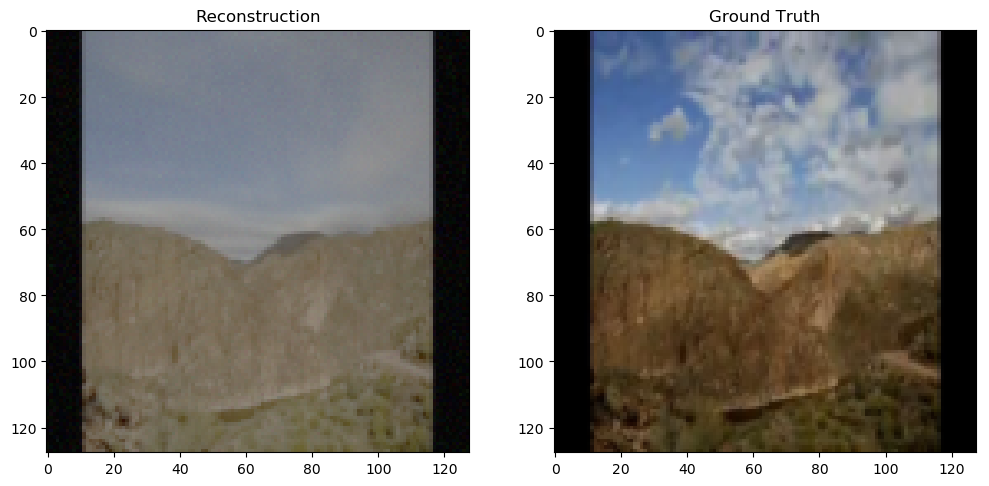

In [40]:
X= next(iter(dl))
X= X[6, :, :].view(input_dim).to(device)

sample_reconst, sample_mean, sample_var = model(X)
sample_reconst = sample_reconst.reshape(3, 128, 128).permute(1, 2, 0).detach().cpu().numpy()

X_img = X.reshape(3, 128, 128).permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.title("Reconstruction")
plt.imshow(sample_reconst)

plt.subplot(122)
plt.title("Ground Truth")
plt.imshow(X_img)

In [41]:
model.eval()

fs = []
for X in dl:
    for i in range(X.shape[0]):
        s = X[i, :, :].reshape(input_dim).to(device)

        sample_reconst, sample_mean, sample_var = model(s)
        sample_reconst = sample_reconst.reshape(3, 128, 128).permute(1, 2, 0).detach().cpu().numpy()
        sample_reconst = cv2.cvtColor(sample_reconst, cv2.COLOR_BGR2RGB)

        fs.append(sample_reconst)

In [42]:
vid = cv2.VideoWriter('apache1_reconst.mp4',cv2.VideoWriter_fourcc(*"XVID"),24,(128,128))

for f in fs:
    f = (f*255).astype(np.uint8)
    vid.write(f)

vid.release()